#  The dataset is located at openneuro.org and its OpenNeuro Accession Number: ds003685 Files: 5398 Size: 30.52GB

## Installations:
If handling EEG / brain -imaging data for the first time. Create a separate conda environment on your machine and install some specialized modules

### Install mne_bids and mne in one shot:
    conda create --name mne --channel conda-forge mne-bids

### Alternatively,install mne-python first, 
conda create --name=mne --channel=conda-forge mne

details here: https://mne.tools/stable/index.html

mne-python is the most popular open source tool for EEG. It is quite mature, allows for good interactive visualization of brain imaging data including EEG
If using an M1 mac, be mindful of arm64 specific environment; if planning to use built-in GPU for keras / tensorflow DL

### install openneuro.py:
pip install openneuro-py

## Exploring ds03685 dataset with mne_bids

In [1]:
import os
import os.path as op
import openneuro
import mne
import matplotlib.pyplot as plt
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report, inspect_dataset
import pandas as pd
import numpy as np
from glob import glob
import pickle
from tqdm import tqdm
%matplotlib qt


In [ ]:
# imports from Arshy's prepdata_final notebook; not sure if these are needed
#from pathlib import Path
#from fastcore.parallel import parallel

In [2]:
# more imports from Arshy's prepdata_final notebook
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler

In [58]:
# .. note: If the keyword argument include is left out of
#          ``openneuro.download``, the whole dataset will be downloaded.
#          We're just using data from one subject to reduce the time
#          it takes to run the example.

dataset = 'ds003685'
subject = '01'
bids_root = op.join(op.dirname(sample.data_path()), dataset)
if not op.isdir(bids_root):
    os.makedirs(bids_root)

In [59]:
bids_root

'/Users/asgnxt/mne-miniconda/mne_data/ds003685'

In [ ]:
# Download one subject's data from each dataset
openneuro.download(dataset=dataset, target_dir=bids_root,
                   include=[f'sub-{subject}'])

In [ ]:
print(make_report(bids_root))

In [ ]:
print_dir_tree(bids_root, max_depth=4)

In [60]:
subject = '01'
datatype = 'eeg'
session = 'session1' # change to session2, session3 after done with first one
task = 'mathematic' # change when finished
suffix = 'eeg'
bids_path = BIDSPath(subject=subject, session=session, task=task,
                     suffix=suffix, datatype=datatype, root=bids_root)

In [61]:
bids_path

BIDSPath(
root: /Users/asgnxt/mne-miniconda/mne_data/ds003685
datatype: eeg
basename: sub-01_ses-session1_task-mathematic_eeg)

In [62]:
print(bids_path.match())

[BIDSPath(
root: /Users/asgnxt/mne-miniconda/mne_data/ds003685
datatype: eeg
basename: sub-01_ses-session1_task-mathematic_run-3_eeg.eeg), BIDSPath(
root: /Users/asgnxt/mne-miniconda/mne_data/ds003685
datatype: eeg
basename: sub-01_ses-session1_task-mathematic_run-3_eeg.vhdr), BIDSPath(
root: /Users/asgnxt/mne-miniconda/mne_data/ds003685
datatype: eeg
basename: sub-01_ses-session1_task-mathematic_run-3_eeg.vmrk)]


In [63]:
print(bids_path)

/Users/asgnxt/mne-miniconda/mne_data/ds003685/sub-01/ses-session1/eeg/sub-01_ses-session1_task-mathematic_eeg


### Read in the raw data

In [64]:
# get names of the .vhdr files
basenames = []
for i in tqdm(range(0, 3)):
    if bids_path.match()[i].basename[-4:] == 'vhdr':
        basenames.append(bids_path.match()[i])

100%|██████████| 3/3 [00:00<00:00, 152.90it/s]


In [65]:
basenames

[BIDSPath(
 root: /Users/asgnxt/mne-miniconda/mne_data/ds003685
 datatype: eeg
 basename: sub-01_ses-session1_task-mathematic_run-3_eeg.vhdr)]

In [66]:
# iterate through all files and create preprocessed dataframes
df = pd.DataFrame()
for basename in tqdm(basenames):
    raw = read_raw_bids(bids_path=basename, verbose=False)
    raw.load_data()
    raw = raw.filter(0.1,40)
    raw = raw.resample(128, npad="auto") 
    raw_data = raw.get_data()
    df1 = pd.DataFrame(raw_data)
    df = pd.concat([df, df1], sort=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16501 samples (33.002 sec)



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


In [67]:
print(raw.info['sfreq'])

128.0


In [68]:
print(raw.info)

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF3, AF7, Fz, F1, F3, F5, F7, FC1, FC3, FC5, FT7, Cz, C1, ...
 chs: 61 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 line_freq: 50.0
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 128.0 Hz
 subject_info: 242 items (dict)
>


In [78]:
print(raw.info['ch_names'])

['Fp1', 'AF3', 'AF7', 'Fz', 'F1', 'F3', 'F5', 'F7', 'FC1', 'FC3', 'FC5', 'FT7', 'Cz', 'C1', 'C3', 'C5', 'T7', 'CP1', 'CP3', 'CP5', 'TP7', 'TP9', 'Pz', 'P1', 'P3', 'P5', 'P7', 'PO3', 'PO7', 'Oz', 'O1', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'FC2', 'FC4', 'FC6', 'FT8', 'C2', 'C4', 'C6', 'T8', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P2', 'P4', 'P6', 'P8', 'POz', 'PO4', 'PO8', 'O2']


In [91]:
# open a pdf file
!open ../EEG_DL/ref_articles/EEG_10-10-system_64_channel_sharbrough.pdf

In [ ]:
# sensor plotting doesnt work
# raw.plot_sensors(ch_type='eeg')

In [93]:
raw.info['chs'][2]

{'ch_name': 'AF7',
 'coil_type': 1 (FIFFV_COIL_EEG),
 'kind': 2 (FIFFV_EEG_CH),
 'logno': 3,
 'scanno': 3,
 'cal': 1.0,
 'range': 1e-06,
 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'unit': 107 (FIFF_UNIT_V),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'coord_frame': 4 (FIFFV_COORD_HEAD)}

Effective window size : 16.000 (s)
Opening raw-browser...


/var/folders/f6/xkyty3nj32785_c9xjmhv0p80000gn/T/ipykernel_5747/1273200865.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


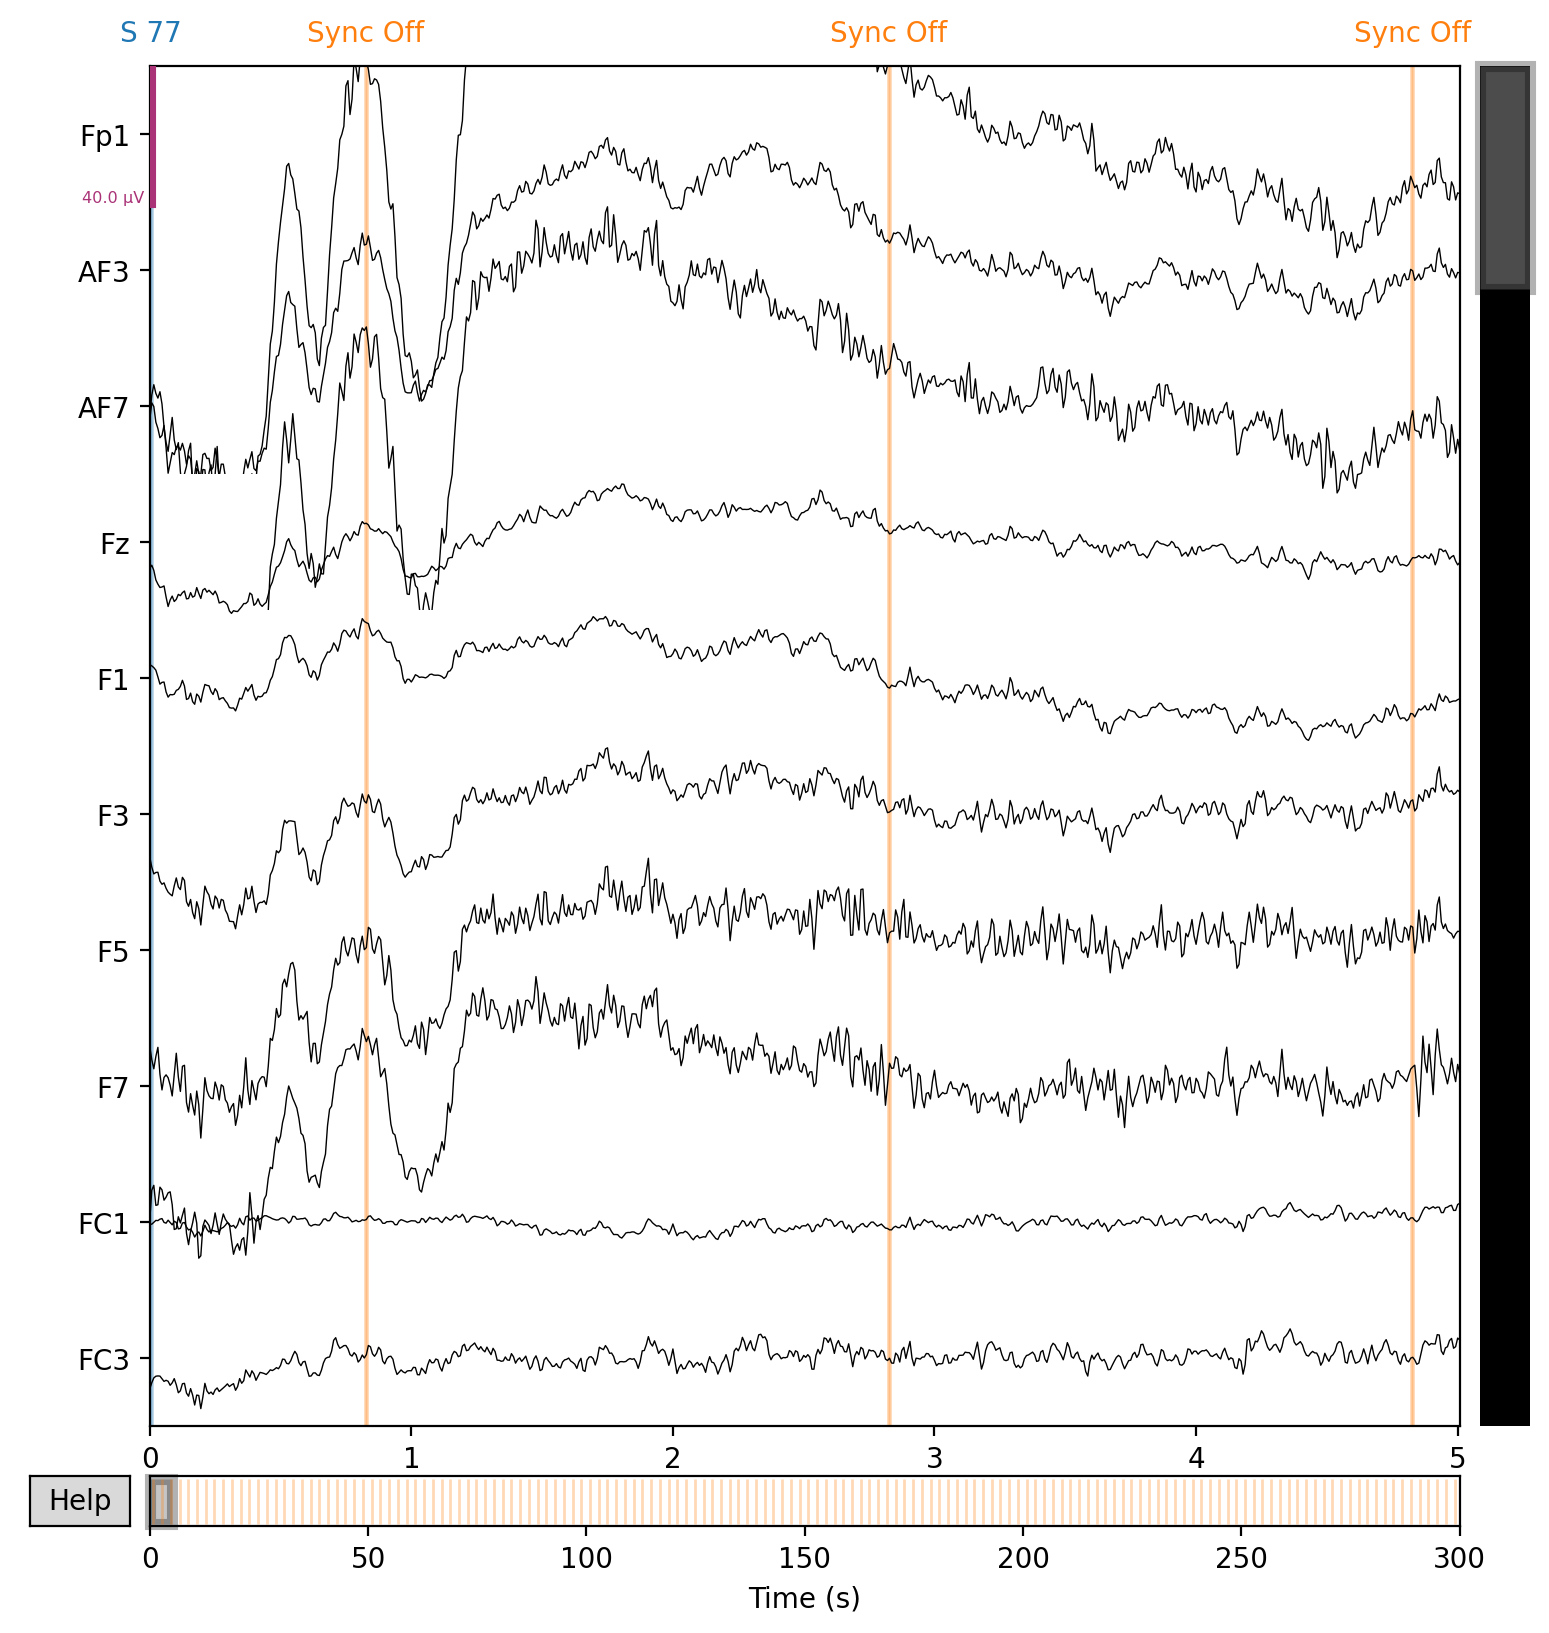

In [75]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=10)

learning MNE Python using; https://www.youtube.com/watch?v=t-twhNqgfSY

# Pre-processing 

## set up and fit the ICA
### (from mne_overview_tutorial.ipynb; currently not working for this dataset)

The pre-processing in the cell below is from Arshy's arshy_prepdata_final.ipynb notebook. Will adapt this to work with the filtered and resampled data above stored as dataframes

### this is from Arshy's script; is converted to markdown to prevent accidental execution; can be converted to Python
def prepare_approach12(fn):
    '''
    approach1
    filter - 1 and 40
    resample - 100hz
    ica - 20 components
    epoch - 50s

    approach2
    same but average all epochs to one   
    '''
    path = f"processeddata/individuals/afterica"
    sub = str(fn).split('/')[-1].split('_')[0]
    session = str(fn).split('/')[-1].split('_')[1]
    label = str(fn).split('/')[-1].split('_')[2]

    raw = mne.io.read_raw_brainvision(fn, preload=True)
    raw = raw.resample(100).filter(l_freq=1, h_freq=40)

    ica = mne.preprocessing.ICA(n_components=20, 
                                random_state=0)
    ica.fit(raw)

    bad_idx_ecg, scores_ecg = ica.find_bads_ecg(raw, 'Fp1', threshold=2)
    bad_idx_eog, scores_eog = ica.find_bads_eog(raw, 'Fp1', threshold=2)
    
    ica.exclude = bad_idx_ecg + bad_idx_eog

    raw_after = ica.apply(raw, 
                          exclude=ica.exclude)

    epochs_after = mne.make_fixed_length_epochs(raw_after,  
                                                duration=50,  
                                                overlap=0)

    fn1 = f"{path}/{label}_{sub}_{session}_approach1.npy"
    fn2 = f"{path}/{label}_{sub}_{session}_approach2.npy"

    np.save(fn1, epochs_after.get_data().astype(np.float16))
    np.save(fn2, epochs_after.average().get_data().astype(np.float16))

In [74]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0, max_iter=800)
ica.fit(raw)

bad_idx_ecg, scores_ecg = ica.find_bads_ecg(raw, 'AF7', threshold=2) # find bad components; from Arshy's prepdata_final notebook cell above
bad_idx_eog, scores_eog = ica.find_bads_eog(raw, 'AF7', threshold=2) # find bad components; from Arshy's prepdata_final notebook cell above
    
ica.exclude = bad_idx_ecg + bad_idx_eog # set bad components to be excluded from further analysis

# ica.plot_properties(raw, picks=ica.exclude)

orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 11.4s.
Using channel AF7 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1280 samples (10.000 sec)

Number of ECG events detected : 440 (average pulse 88 / min.)
Not setting metadata
440 matching events found
No baseline correction applied
Using data from preloaded Raw for 440 events and 129 original time points ...
1 bad epochs dropped


/Users/asgnxt/miniconda3/envs/mne/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Using EOG channel: AF7
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)


<RawBrainVision | sub-01_ses-session1_task-mathematic_run-3_eeg.eeg, 61 x 38400 (300.0 s), ~18.0 MB, data loaded>

In [ ]:
# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)